<a href="https://colab.research.google.com/github/sushirito/ArsenicFR/blob/main/ArsenicAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === Colab setup ===
# If in Colab, run this to mount Drive
from google.colab import drive  # safe if not in Colab
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:


# Optional. Colab already has torch. Keep this if you want a fixed version.
# !pip -q install torch torchvision torchaudio

import os, math, time, random, pickle, json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Reproducibility and dtype
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.set_float32_matmul_precision("medium")
except Exception:
    pass
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
ROOT = "/content/drive/MyDrive/ArsenicSTS"
DATA_CSV = f"{ROOT}/UVVisData/0.30MB_AuNP_As.csv"
CKPT_ROOT = f"{ROOT}/aae_ckpts"
FIG_ROOT = f"{ROOT}/figs"
GEN_ROOT = f"{ROOT}/generated"
os.makedirs(CKPT_ROOT, exist_ok=True)
os.makedirs(FIG_ROOT, exist_ok=True)
os.makedirs(GEN_ROOT, exist_ok=True)

# ===== Data loader and preprocessing =====
def load_uvvis_csv(path, baseline_correct=True):
    """Returns wavelengths [601], conc_list [6], A_mat [601,6] after optional baseline removal at 800 nm."""
    df = pd.read_csv(path)
    # normalize column names to str
    df.columns = [str(c).strip() for c in df.columns]
    assert "Wavelength" in df.columns, "CSV must have 'Wavelength' column"
    wl = df["Wavelength"].to_numpy().astype(np.float32)
    # extract concentration columns that are numeric when cast to float
    conc_cols = []
    for c in df.columns:
        if c == "Wavelength":
            continue
        try:
            float(c)
            conc_cols.append(c)
        except Exception:
            pass
    # sort by numeric concentration ascending
    conc_vals = np.array(sorted([float(c) for c in conc_cols], key=float), dtype=np.float32)
    conc_cols_sorted = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_vals]
    # Build matrix in that order
    A = np.stack([df[c].to_numpy().astype(np.float32) for c in conc_cols_sorted], axis=1)  # [601,6]
    # Optional baseline correction using A at 800 nm
    if baseline_correct:
        # find index of 800 nm
        idx_800 = int(np.argmin(np.abs(wl - 800.0)))
        base = A[idx_800:idx_800+1, :]  # [1,6]
        A = A - base
    return wl, conc_vals, A

def split_loco(concs):
    """Yield folds with one held concentration each."""
    for c_hold in concs:
        train = [c for c in concs if c != c_hold]
        yield c_hold, np.array(train, dtype=np.float32)

class SpectraScaler:
    """Featurewise standardization using training stats only. Works on [N,601] row vectors."""
    def __init__(self):
        self.mean = None
        self.std = None
    def fit(self, X):  # X [N,601]
        self.mean = X.mean(axis=0, keepdims=True)
        self.std  = X.std(axis=0, keepdims=True) + 1e-6
    def transform(self, X):
        return (X - self.mean) / self.std
    def inverse(self, Xz):
        return Xz * self.std + self.mean
    def save(self, path):
        with open(path, "wb") as f:
            pickle.dump({"mean": self.mean, "std": self.std}, f)
    @staticmethod
    def load(path):
        with open(path, "rb") as f:
            d = pickle.load(f)
        sc = SpectraScaler()
        sc.mean, sc.std = d["mean"], d["std"]
        return sc

# Load data
wl, concs_all, A = load_uvvis_csv(DATA_CSV, baseline_correct=True)  # A [601,6]
assert A.shape[0] == 601, "Expected 601 wavelengths"
assert A.shape[1] == len(concs_all), "Mismatch in concentration columns"
print("Wavelengths:", wl.shape, "Concentrations:", concs_all, "A:", A.shape)

# Build per-spectrum dataset
# Each column is a sample x in R^601 and scalar c in µg/L
SPECTRA = {float(c): A[:, i].astype(np.float32) for i, c in enumerate(concs_all)}
WL_MIN, WL_MAX = wl.min(), wl.max()
C_MIN, C_MAX = float(concs_all.min()), float(concs_all.max())

def scale_c(c, cmin=C_MIN, cmax=C_MAX):
    return (c - cmin) / (cmax - cmin + 1e-12)

def unscale_c(cs, cmin=C_MIN, cmax=C_MAX):
    return cs * (cmax - cmin) + cmin


Wavelengths: (601,) Concentrations: [ 0. 10. 20. 30. 40. 60.] A: (601, 6)


In [6]:
# ===== Small MLP building block =====
class MLP(nn.Module):
    def __init__(self, in_dim, hidden, out_dim, n_layers=3, act=nn.SiLU, layernorm=True, final_act=None):
        super().__init__()
        dims = [in_dim] + [hidden]*n_layers + [out_dim]
        layers = []
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i], dims[i+1])]
            if layernorm:
                layers += [nn.LayerNorm(dims[i+1])]
            layers += [act()]
        layers += [nn.Linear(dims[-2], dims[-1])]
        if final_act is not None:
            layers += [final_act()]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# ===== AAE components =====
class Encoder(nn.Module):
    def __init__(self, in_dim=601, hidden=256, latent_dim=4, n_layers=3):
        super().__init__()
        self.f = MLP(in_dim, hidden, latent_dim, n_layers=n_layers, act=nn.SiLU, layernorm=True)
    def forward(self, x):
        return self.f(x)

class CEmbed(nn.Module):
    def __init__(self, emb_dim=8):
        super().__init__()
        self.f = MLP(1, hidden=16, out_dim=emb_dim, n_layers=1, act=nn.SiLU, layernorm=False)
    def forward(self, c01):
        return self.f(c01)

class Decoder(nn.Module):
    def __init__(self, latent_dim=4, c_emb_dim=8, hidden=256, out_dim=601, n_layers=3):
        super().__init__()
        self.f = MLP(latent_dim + c_emb_dim, hidden, out_dim, n_layers=n_layers, act=nn.SiLU, layernorm=True)
    def forward(self, z, cemb):
        h = torch.cat([z, cemb], dim=-1)
        return self.f(h)

class Discriminator(nn.Module):
    def __init__(self, latent_dim=4, hidden=128):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(latent_dim, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, z):
        return self.f(z)  # logits

class AuxRegressor(nn.Module):
    def __init__(self, latent_dim=4):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(latent_dim, 32), nn.SiLU(),
            nn.Linear(32, 1)
        )
    def forward(self, z):
        return self.f(z)  # predicts c_scaled


In [7]:
# ===== Utilities =====
def rmse(a, b):
    return float(np.sqrt(np.mean((a - b)**2)))

def pearsonr(a, b):
    a = a - a.mean(); b = b - b.mean()
    return float((a*b).sum() / (np.sqrt((a*a).sum()) * np.sqrt((b*b).sum()) + 1e-12))

def peak_nm(wl, spec):
    return float(wl[int(np.argmax(spec))])

def linear_baseline_interp(concs_known, A_known, c_target):
    """Interpolate at each wavelength separately using two nearest neighbors in conc space.
       A_known shape [601, K] for K known concs in ascending concs_known."""
    concs = np.array(concs_known, dtype=np.float32)
    A_kn = np.array(A_known, dtype=np.float32)  # [601,K]
    # find left and right neighbors for c_target
    if c_target <= concs.min():
        # extrapolate using first two
        i0, i1 = 0, 1
    elif c_target >= concs.max():
        i0, i1 = len(concs)-2, len(concs)-1
    else:
        i1 = int(np.searchsorted(concs, c_target, side="right"))
        i0 = i1 - 1
    c0, c1 = concs[i0], concs[i1]
    w = (c_target - c0) / (c1 - c0 + 1e-12)
    return (1 - w) * A_kn[:, i0] + w * A_kn[:, i1]

def make_batch(X, C, batch_size):
    n = X.shape[0]
    idx = np.random.randint(0, n, size=(batch_size,))
    return torch.from_numpy(X[idx]).float().to(DEVICE), torch.from_numpy(C[idx]).float().to(DEVICE)

def save_fold_artifacts(fold_dir, enc, dec, disc, aux, scaler, meta):
    os.makedirs(fold_dir, exist_ok=True)
    torch.save(enc.state_dict(),  os.path.join(fold_dir, "encoder.pt"))
    torch.save(dec.state_dict(),  os.path.join(fold_dir, "decoder.pt"))
    torch.save(disc.state_dict(), os.path.join(fold_dir, "disc.pt"))
    torch.save(aux.state_dict(),  os.path.join(fold_dir, "aux.pt"))
    scaler.save(os.path.join(fold_dir, "scaler.pkl"))
    with open(os.path.join(fold_dir, "meta.json"), "w") as f:
        json.dump(meta, f, indent=2)

def load_fold(fold_dir, latent_dim=4, c_emb_dim=8):
    enc = Encoder(latent_dim=latent_dim).to(DEVICE)
    dec = Decoder(latent_dim=latent_dim, c_emb_dim=c_emb_dim).to(DEVICE)
    disc = Discriminator(latent_dim=latent_dim).to(DEVICE)
    aux = AuxRegressor(latent_dim=latent_dim).to(DEVICE)
    enc.load_state_dict(torch.load(os.path.join(fold_dir, "encoder.pt"), map_location=DEVICE))
    dec.load_state_dict(torch.load(os.path.join(fold_dir, "decoder.pt"), map_location=DEVICE))
    disc.load_state_dict(torch.load(os.path.join(fold_dir, "disc.pt"), map_location=DEVICE))
    aux.load_state_dict(torch.load(os.path.join(fold_dir, "aux.pt"), map_location=DEVICE))
    scaler = SpectraScaler.load(os.path.join(fold_dir, "scaler.pkl"))
    with open(os.path.join(fold_dir, "meta.json"), "r") as f:
        meta = json.load(f)
    cembed = CEmbed(emb_dim=meta["c_emb_dim"]).to(DEVICE)
    cembed.load_state_dict(torch.load(os.path.join(fold_dir, "cembed.pt"), map_location=DEVICE))
    return enc.eval(), dec.eval(), disc.eval(), aux.eval(), cembed.eval(), scaler, meta


In [8]:
# ===== Core trainer for one LOCO fold =====
def train_fold(fold_spec,
               latent_dim=4, c_emb_dim=8, batch_size=32,
               max_steps=6000, patience=500,
               w_rec=0.9, w_adv=0.1, w_aux=0.05,
               lr=4e-4, lr_min=1e-5):

    c_hold = float(fold_spec["c_hold"])
    train_concs = np.array(fold_spec["train_concs"], dtype=np.float32)
    fold_dir = os.path.join(CKPT_ROOT, f"fold_{int(c_hold)}")
    os.makedirs(fold_dir, exist_ok=True)

    # Build training arrays
    X_train = np.stack([SPECTRA[c] for c in train_concs], axis=0)  # [5,601]
    C_train = np.array([scale_c(c) for c in train_concs], dtype=np.float32).reshape(-1,1)

    scaler = SpectraScaler(); scaler.fit(X_train)  # featurewise
    Xz = scaler.transform(X_train).astype(np.float32)

    # Tiny dataset. We will repeatedly sample minibatches from it.
    # Validation proxy will be EMA of training recon loss.
    # Models
    enc = Encoder(latent_dim=latent_dim).to(DEVICE)
    cembed = CEmbed(emb_dim=c_emb_dim).to(DEVICE)
    dec = Decoder(latent_dim=latent_dim, c_emb_dim=c_emb_dim).to(DEVICE)
    disc = Discriminator(latent_dim=latent_dim).to(DEVICE)
    aux = AuxRegressor(latent_dim=latent_dim).to(DEVICE)

    # Opts and sched
    opt_g = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()) +
                             list(cembed.parameters()) + list(aux.parameters()), lr=lr)
    T_max = max_steps
    sch_g = torch.optim.lr_scheduler.CosineAnnealingLR(opt_g, T_max=T_max, eta_min=lr_min)

    opt_d = torch.optim.Adam(disc.parameters(), lr=lr*0.5)

    bce = nn.BCEWithLogitsLoss()
    mse = nn.MSELoss()

    best_rec = float("inf")
    best_step = 0
    ema_rec = None
    hist = {"step": [], "rec": [], "adv": [], "aux": []}

    Xnp = Xz.astype(np.float32); Cnp = C_train.astype(np.float32)

    for step in range(1, max_steps+1):
        # Make a batch by resampling from the 5 rows
        xb, cb = make_batch(Xnp, Cnp, batch_size)
        z = enc(xb)  # [B,L]
        cemb = cembed(cb)  # [B,E]
        x_rec = dec(z, cemb)

        # --- Discriminator update ---
        # Prior samples as "real"
        z_real = torch.randn_like(z)
        logits_real = disc(z_real)
        logits_fake = disc(z.detach())
        d_loss = bce(logits_real, torch.ones_like(logits_real)) + \
                 bce(logits_fake, torch.zeros_like(logits_fake))
        opt_d.zero_grad(set_to_none=True)
        d_loss.backward()
        opt_d.step()

        # --- Generator (E+D+H) update ---
        rec = mse(x_rec, xb)
        # fool the discriminator
        logits_fake2 = disc(z)
        adv = bce(logits_fake2, torch.ones_like(logits_fake2))
        # auxiliary
        c_pred = aux(z)
        aux_loss = mse(c_pred, cb)
        loss = w_rec*rec + w_adv*adv + w_aux*aux_loss

        opt_g.zero_grad(set_to_none=True)
        loss.backward()
        opt_g.step()
        sch_g.step()

        # Track
        rec_val = float(rec.detach().cpu())
        ema_rec = rec_val if ema_rec is None else 0.98*ema_rec + 0.02*rec_val
        hist["step"].append(step); hist["rec"].append(rec_val)
        hist["adv"].append(float(adv.detach().cpu()))
        hist["aux"].append(float(aux_loss.detach().cpu()))

        # Early stopping on best raw rec
        if rec_val < best_rec - 1e-6:
            best_rec = rec_val
            best_step = step
            # Save best so far
            torch.save(enc.state_dict(),  os.path.join(fold_dir, "encoder.pt"))
            torch.save(dec.state_dict(),  os.path.join(fold_dir, "decoder.pt"))
            torch.save(disc.state_dict(), os.path.join(fold_dir, "disc.pt"))
            torch.save(aux.state_dict(),  os.path.join(fold_dir, "aux.pt"))
            torch.save(cembed.state_dict(), os.path.join(fold_dir, "cembed.pt"))
            scaler.save(os.path.join(fold_dir, "scaler.pkl"))
            with open(os.path.join(fold_dir, "train_hist.json"), "w") as f:
                json.dump(hist, f)
        if step - best_step >= patience:
            print(f"[fold {int(c_hold)}] Early stop at {step}. Best step {best_step} rec {best_rec:.4e}")
            break

    # Meta
    meta = {
        "c_hold": float(c_hold),
        "train_concs": [float(x) for x in train_concs.tolist()],
        "latent_dim": int(latent_dim),
        "c_emb_dim": int(c_emb_dim),
        "best_step": int(best_step),
        "best_rec": float(best_rec),
        "w_rec": float(w_rec), "w_adv": float(w_adv), "w_aux": float(w_aux),
        "lr": float(lr), "lr_min": float(lr_min),
        "max_steps": int(max_steps), "patience": int(patience)
    }
    with open(os.path.join(fold_dir, "meta.json"), "w") as f:
        json.dump(meta, f, indent=2)

    # Return quick info
    return {"fold_dir": fold_dir, "meta": meta, "best_rec": best_rec}


In [9]:
# ===== Generation helpers =====
def decode_many(dec, cembed, scaler, c_target, N, latent_dim, c_emb_dim):
    with torch.no_grad():
        z = torch.randn(N, latent_dim, device=DEVICE)
        c01 = torch.full((N,1), fill_value=scale_c(c_target), device=DEVICE)
        cemb = cembed(c01)
        xz = dec(z, cemb)  # standardized
        x = scaler.inverse(xz.detach().cpu().numpy())
    return x  # [N,601]

def filtered_reject(dec, cembed, aux, scaler, c_target, N, latent_dim, eps=0.02, max_trials=20000):
    out = []
    trials = 0
    ct = torch.tensor([[scale_c(c_target)]], device=DEVICE)
    while len(out) < N and trials < max_trials:
        trials += 256
        z = torch.randn(256, latent_dim, device=DEVICE)
        c_pred = aux(z)
        mask = (c_pred - ct).abs() <= eps
        if mask.any():
            z_keep = z[mask.squeeze(1)]
            with torch.no_grad():
                cemb = cembed(ct.repeat(z_keep.size(0),1))
                xz = dec(z_keep, cemb)
            x = scaler.inverse(xz.detach().cpu().numpy())
            out.append(x)
    if len(out) == 0:
        return np.zeros((0, 601), dtype=np.float32)
    X = np.concatenate(out, axis=0)
    return X[:N]

def filtered_opt(dec, cembed, aux, scaler, c_target, N, latent_dim, steps=200, lr=0.05, lam=0.01, sigma=0.05):
    # gradient-based targeting toward c*
    X = []
    ct = torch.tensor([[scale_c(c_target)]], device=DEVICE)
    for _ in range(N):
        z = torch.randn(1, latent_dim, device=DEVICE, requires_grad=True)
        opt = torch.optim.Adam([z], lr=lr)
        for _ in range(steps):
            cp = aux(z)
            loss = (cp - ct).pow(2).mean() + lam*(z.pow(2).mean())
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()
        # small local noise
        z_final = z.detach() + sigma*torch.randn_like(z)
        with torch.no_grad():
            cemb = cembed(ct)
            xz = dec(z_final, cemb)
        X.append(scaler.inverse(xz.detach().cpu().numpy()))
    return np.concatenate(X, axis=0)

# ===== Public API =====
_LAST_FOLD_CACHE = {}  # c_hold -> loaded modules

def _pick_fold_for_c(c_target):
    # Choose fold that held the nearest concentration to c_target
    diffs = {float(c): abs(c_target - float(c)) for c in concs_all}
    nearest = min(diffs, key=diffs.get)
    return int(nearest)

def _load_fold_cached(c_hold):
    if c_hold in _LAST_FOLD_CACHE:
        return _LAST_FOLD_CACHE[c_hold]
    fold_dir = os.path.join(CKPT_ROOT, f"fold_{int(c_hold)}")
    enc, dec, disc, aux, cemb, scaler, meta = load_fold(fold_dir)
    _LAST_FOLD_CACHE[c_hold] = (enc, dec, disc, aux, cemb, scaler, meta)
    return _LAST_FOLD_CACHE[c_hold]

def generate_spectra(c_target, N=64, mode="conditional"):
    """Returns np.ndarray [N,601] in baseline-corrected absorbance space."""
    fold_to_use = _pick_fold_for_c(c_target)
    enc, dec, disc, aux, cemb, scaler, meta = _load_fold_cached(fold_to_use)
    latent_dim = meta["latent_dim"]; c_emb_dim = meta["c_emb_dim"]

    if mode == "conditional":
        X = decode_many(dec, cemb, scaler, c_target, N, latent_dim, c_emb_dim)
    elif mode == "filtered_reject":
        X = filtered_reject(dec, cemb, aux, scaler, c_target, N, latent_dim, eps=0.02)
    elif mode == "filtered_opt":
        X = filtered_opt(dec, cemb, aux, scaler, c_target, N, latent_dim, steps=200, lr=0.05, lam=0.01, sigma=0.05)
    else:
        raise ValueError("mode must be one of {'conditional','filtered_reject','filtered_opt'}")
    # Save optional dump
    np.save(os.path.join(GEN_ROOT, f"gen_c_{int(round(c_target))}_{mode}.npy"), X.astype(np.float32))
    return X


In [10]:
def evaluate_loco(N=64, modes=("conditional","filtered_opt")):
    rows = []
    for c_hold, train_concs in split_loco(concs_all):
        # train this fold if not already present
        fold_dir = os.path.join(CKPT_ROOT, f"fold_{int(c_hold)}")
        if not os.path.exists(os.path.join(fold_dir, "encoder.pt")):
            print(f"Training fold for held {int(c_hold)}")
            train_fold({"c_hold": float(c_hold), "train_concs": train_concs})
        # load trained
        enc, dec, disc, aux, cemb, scaler, meta = load_fold(fold_dir)
        latent_dim = meta["latent_dim"]; c_emb_dim = meta["c_emb_dim"]

        # Real held spectrum in baseline-corrected space with same scaler
        x_true = SPECTRA[float(c_hold)]
        # for baseline comparison we build linear interpolation from training concs and spectra
        A_train_mat = np.stack([SPECTRA[float(c)] for c in train_concs], axis=1)
        lin_pred = linear_baseline_interp(train_concs, A_train_mat, float(c_hold))

        # For metrics, we compare mean generated spectrum to real held
        for mode in modes:
            if mode == "conditional":
                X = decode_many(dec, cemb, scaler, float(c_hold), N, latent_dim, c_emb_dim)
            elif mode == "filtered_opt":
                X = filtered_opt(dec, cemb, aux, scaler, float(c_hold), N, latent_dim, steps=200, lr=0.05, lam=0.01, sigma=0.05)
            elif mode == "filtered_reject":
                X = filtered_reject(dec, cemb, aux, scaler, float(c_hold), N, latent_dim, eps=0.02)
            else:
                continue
            x_mean = X.mean(axis=0)

            r = pearsonr(x_true, x_mean)
            e = rmse(x_true, x_mean)
            p_err = abs(peak_nm(wl, x_true) - peak_nm(wl, x_mean))

            # linear baseline metrics
            e_lin = rmse(x_true, lin_pred)
            r_lin = pearsonr(x_true, lin_pred)

            rows.append({
                "c_hold": float(c_hold),
                "mode": mode,
                "rmse": e,
                "pearson_r": r,
                "peak_shift_nm": p_err,
                "rmse_linear": e_lin,
                "pearson_r_linear": r_lin
            })

            # Plot overlay and uncertainty band
            fig = plt.figure(figsize=(8,4))
            plt.plot(wl, x_true, label=f"Real c={int(c_hold)}")
            plt.plot(wl, x_mean, label=f"AAE mean {mode}")
            # uncertainty band
            std = X.std(axis=0)
            plt.fill_between(wl, x_mean-std, x_mean+std, alpha=0.2, label="AAE ±1 sd")
            # linear baseline
            plt.plot(wl, lin_pred, linestyle=":", label="Linear baseline")
            plt.xlabel("Wavelength (nm)"); plt.ylabel("Absorbance (baseline corrected)")
            plt.legend(loc="best")
            plt.tight_layout()
            outpng = os.path.join(FIG_ROOT, f"loco_c_{int(c_hold)}_{mode}.png")
            plt.savefig(outpng, dpi=160); plt.close(fig)

        # Save a CSV of generated mean spectra for this held concentration
        out_csv = os.path.join(GEN_ROOT, f"loco_c_{int(c_hold)}.csv")
        cols = {}
        for mode in modes:
            # regenerate to avoid storing large arrays
            if mode == "conditional":
                X = decode_many(dec, cemb, scaler, float(c_hold), N, latent_dim, c_emb_dim)
            else:
                X = filtered_opt(dec, cemb, aux, scaler, float(c_hold), N, latent_dim)
            cols[f"gen_mean_{mode}"] = X.mean(axis=0)
        df = pd.DataFrame({"Wavelength": wl, "Real": x_true, "Linear": lin_pred, **cols})
        df.to_csv(out_csv, index=False)

    dfres = pd.DataFrame(rows)
    dfres_path = os.path.join(ROOT, "loco_results.csv")
    dfres.to_csv(dfres_path, index=False)
    print("Saved LOCO results to", dfres_path)
    return dfres

def generate_grid(c_values, N_per=32, mode="conditional"):
    out = {}
    rows = []
    for c in c_values:
        X = generate_spectra(c, N=N_per, mode=mode)
        out[c] = X
        rows.append(np.concatenate([[c], X.mean(axis=0)], axis=0))
    grid = np.stack(rows, axis=0)
    cols = ["c"] + [f"{int(w)}" for w in wl]
    df = pd.DataFrame(grid, columns=cols)
    csv_path = os.path.join(GEN_ROOT, "gen_grid_interp.csv")
    df.to_csv(csv_path, index=False)
    return out


In [11]:
# ===== Train all folds and print LOCO table =====
metrics = evaluate_loco()   # trains missing folds, evaluates modes: conditional and filtered_opt
print(metrics)

# ===== Interpolate at c*=25 using conditional decoding =====
specs = generate_spectra(25.0, N=64, mode="conditional")
print("Generated specs shape:", specs.shape)

# ===== Same using filtered optimization =====
specs_opt = generate_spectra(25.0, N=64, mode="filtered_opt")
print("Generated specs_opt shape:", specs_opt.shape)

# ===== Smoothness diagnostic across midpoints =====
midpoints = [5, 15, 25, 35, 50]
grid = generate_grid(midpoints, N_per=32, mode="conditional")

# Simple smoothness score by total variation across concentrations
means = np.stack([grid[c].mean(axis=0) for c in midpoints], axis=0)  # [M,601]
tv = np.abs(np.diff(means, axis=0)).sum()  # scalar
print("Total variation across c midpoints:", float(tv))


Training fold for held 0
[fold 0] Early stop at 1983. Best step 1483 rec 2.2747e-05
Training fold for held 10
[fold 10] Early stop at 1395. Best step 895 rec 3.2301e-05
Training fold for held 20
[fold 20] Early stop at 1006. Best step 506 rec 1.7088e-05
Training fold for held 30
[fold 30] Early stop at 1117. Best step 617 rec 1.6933e-05
Training fold for held 40
[fold 40] Early stop at 1725. Best step 1225 rec 2.4530e-05
Training fold for held 60
[fold 60] Early stop at 1378. Best step 878 rec 6.8582e-05
Saved LOCO results to /content/drive/MyDrive/ArsenicSTS/loco_results.csv
    c_hold          mode      rmse  pearson_r  peak_shift_nm  rmse_linear  \
0      0.0   conditional  0.013299   0.955343            0.0     0.041023   
1      0.0  filtered_opt  0.027287   0.868159            0.0     0.041023   
2     10.0   conditional  0.013565   0.979066            0.0     0.020511   
3     10.0  filtered_opt  0.003823   0.991086            0.0     0.020511   
4     20.0   conditional  0.0285

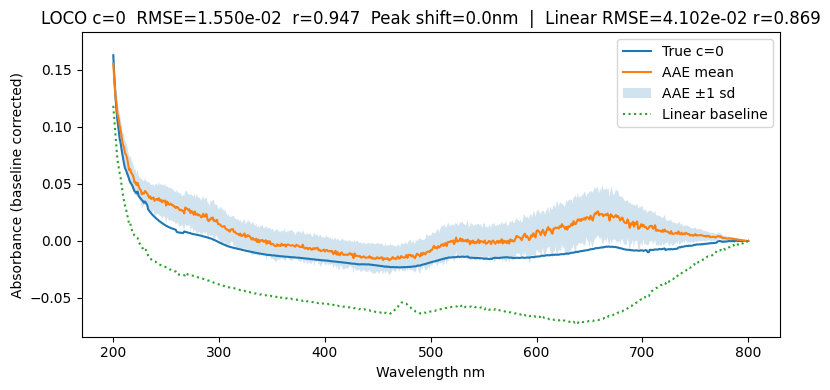

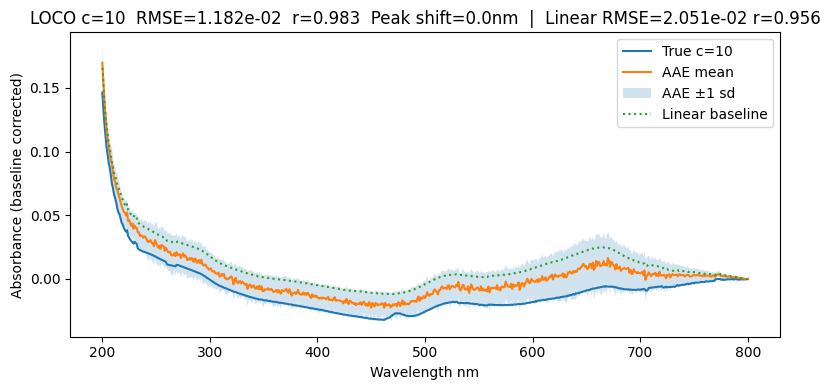

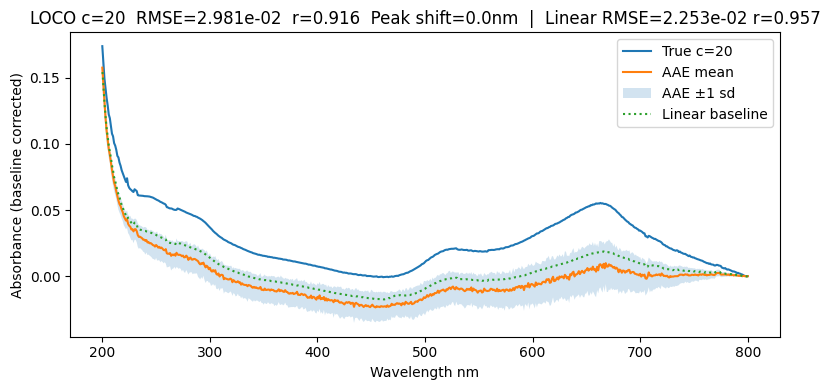

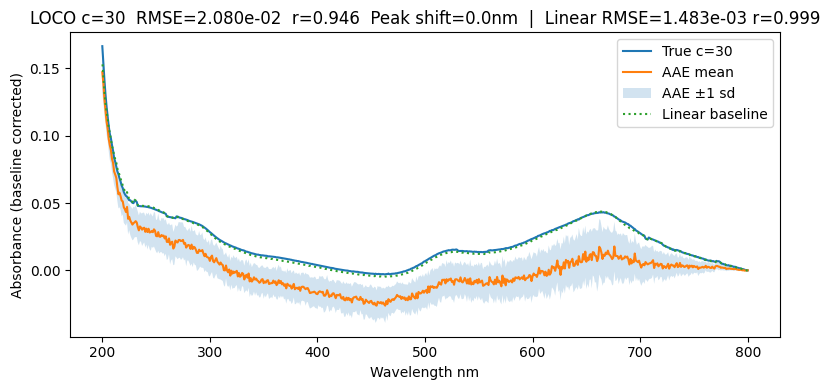

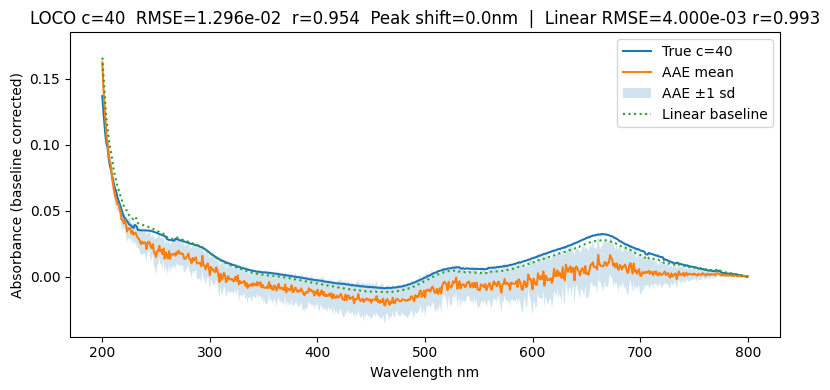

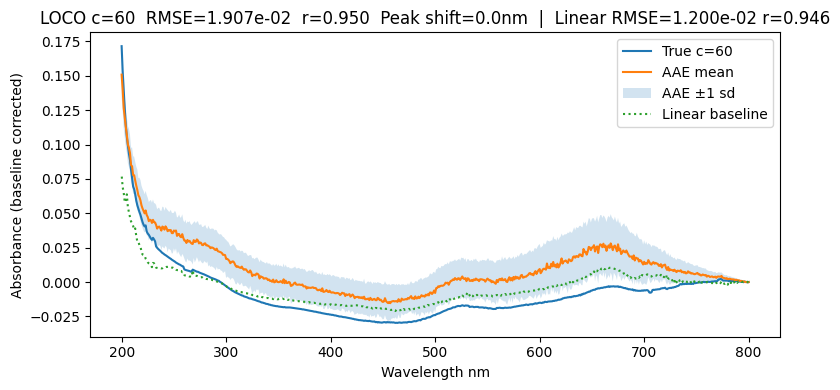

c_hold | RMSE_AAE | r_AAE | PeakShift_nm | RMSE_Lin | r_Lin
    0 | 1.550e-02 | 0.947 |   0.00       | 4.102e-02 | 0.869
   10 | 1.182e-02 | 0.983 |   0.00       | 2.051e-02 | 0.956
   20 | 2.981e-02 | 0.916 |   0.00       | 2.253e-02 | 0.957
   30 | 2.080e-02 | 0.946 |   0.00       | 1.483e-03 | 0.999
   40 | 1.296e-02 | 0.954 |   0.00       | 4.000e-03 | 0.993
   60 | 1.907e-02 | 0.950 |   0.00       | 1.200e-02 | 0.946


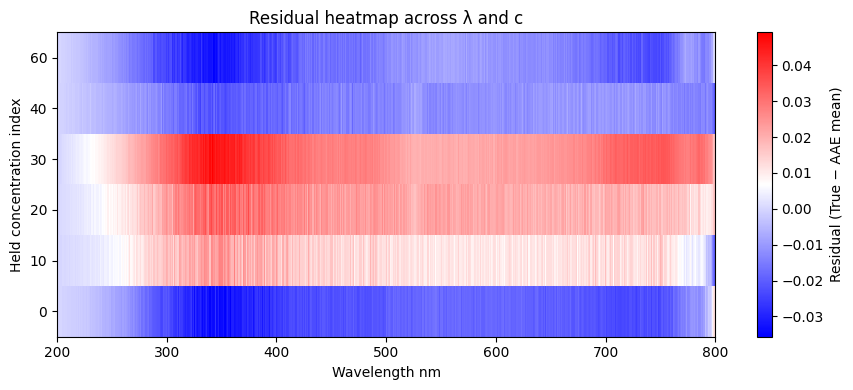

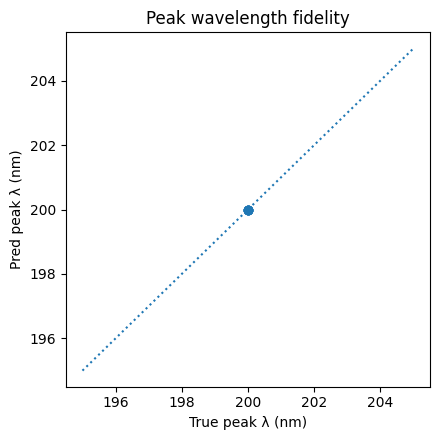

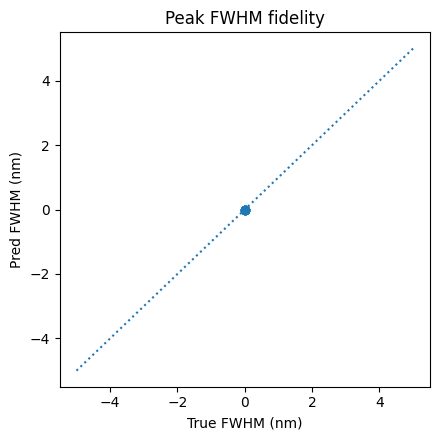

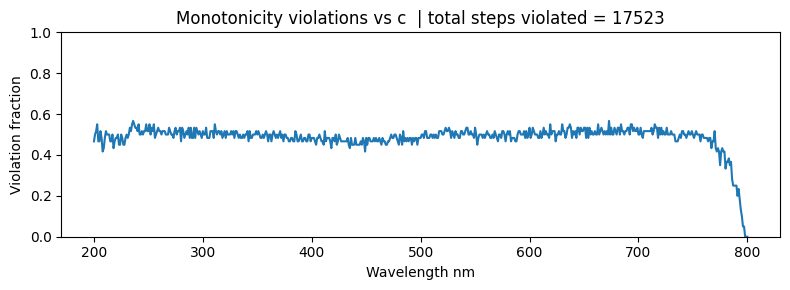

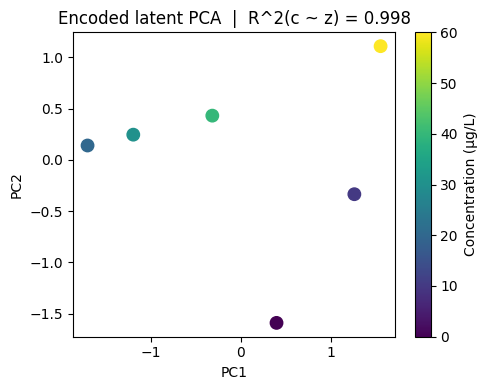

In [11]:
# ====== Quick diagnostics: 5 easiest, high-signal tests ======
import os, json, numpy as np, torch, matplotlib.pyplot as plt

assert 'wl' in globals() and 'concs_all' in globals() and 'SPECTRA' in globals(), "Run your data loader first"
assert 'load_fold' in globals() and 'decode_many' in globals() and 'linear_baseline_interp' in globals(), "Run your AAE code first"

# ---------- helpers ----------
def fwhm_nm(wl, y):
    y = np.asarray(y)
    p = int(np.argmax(y))
    half = y[p] / 2.0
    # left crossing
    li = p
    while li > 0 and y[li] > half: li -= 1
    if li == p:
        left = wl[p]
    else:
        # linear interp between li and li+1
        x0, x1 = wl[li], wl[li+1]; y0, y1 = y[li], y[li+1]
        left = x0 if y1==y0 else x0 + (half - y0) * (x1 - x0) / (y1 - y0)
    # right crossing
    ri = p
    while ri < len(y)-1 and y[ri] > half: ri += 1
    if ri == p:
        right = wl[p]
    else:
        x0, x1 = wl[ri-1], wl[ri]; y0, y1 = y[ri-1], y[ri]
        right = x1 if y1==y0 else x0 + (half - y0) * (x1 - x0) / (y1 - y0)
    return max(0.0, float(right - left))

def rmse(a, b): a = np.asarray(a); b = np.asarray(b); return float(np.sqrt(np.mean((a-b)**2)))
def pearsonr(a, b):
    a = np.asarray(a); b = np.asarray(b)
    a = a - a.mean(); b = b - b.mean()
    den = np.sqrt((a*a).sum()) * np.sqrt((b*b).sum()) + 1e-12
    return float((a*b).sum() / den)

def peak_nm(wl, y): return float(wl[int(np.argmax(y))])

def load_fold_pack(c_hold):
    fold_dir = os.path.join(CKPT_ROOT, f"fold_{int(c_hold)}")
    if not os.path.exists(os.path.join(fold_dir, "encoder.pt")):
        raise FileNotFoundError(f"Missing {fold_dir}. Train LOCO folds first.")
    enc, dec, disc, aux, cemb, scaler, meta = load_fold(fold_dir)
    return {"enc":enc, "dec":dec, "aux":aux, "cemb":cemb, "scaler":scaler, "meta":meta}

def aae_mean_std_at(c_hold, N=128, mode="conditional"):
    P = load_fold_pack(c_hold); L = P["meta"]["latent_dim"]; E = P["meta"]["c_emb_dim"]
    if mode == "conditional":
        X = decode_many(P["dec"], P["cemb"], P["scaler"], float(c_hold), N, L, E)
    else:
        # fallback to conditional for simplicity here
        X = decode_many(P["dec"], P["cemb"], P["scaler"], float(c_hold), N, L, E)
    return X.mean(axis=0), X.std(axis=0)

# ---------- 1) LOCO overlay with uncertainty and linear baseline ----------
rows = []
for c_hold in concs_all:
    P = load_fold_pack(c_hold)
    train_concs = [float(c) for c in concs_all if float(c) != float(c_hold)]
    A_train = np.stack([SPECTRA[float(c)] for c in train_concs], axis=1)
    lin_pred = linear_baseline_interp(train_concs, A_train, float(c_hold))

    mean_pred, std_pred = aae_mean_std_at(c_hold, N=128, mode="conditional")
    x_true = SPECTRA[float(c_hold)]

    r = pearsonr(x_true, mean_pred)
    e = rmse(x_true, mean_pred)
    pshift = abs(peak_nm(wl, x_true) - peak_nm(wl, mean_pred))
    r_lin = pearsonr(x_true, lin_pred)
    e_lin = rmse(x_true, lin_pred)

    plt.figure(figsize=(8,4))
    plt.plot(wl, x_true, label=f"True c={int(c_hold)}")
    plt.plot(wl, mean_pred, label="AAE mean")
    plt.fill_between(wl, mean_pred-std_pred, mean_pred+std_pred, alpha=0.2, label="AAE ±1 sd")
    plt.plot(wl, lin_pred, linestyle=":", label="Linear baseline")
    plt.title(f"LOCO c={int(c_hold)}  RMSE={e:.3e}  r={r:.3f}  Peak shift={pshift:.1f}nm  |  Linear RMSE={e_lin:.3e} r={r_lin:.3f}")
    plt.xlabel("Wavelength nm"); plt.ylabel("Absorbance (baseline corrected)"); plt.legend(); plt.tight_layout(); plt.show()

    rows.append((float(c_hold), e, r, pshift, e_lin, r_lin))

# quick table print
print("c_hold | RMSE_AAE | r_AAE | PeakShift_nm | RMSE_Lin | r_Lin")
for r in rows:
    print(f"{int(r[0]):>5} | {r[1]:.3e} | {r[2]:.3f} | {r[3]:6.2f}       | {r[4]:.3e} | {r[5]:.3f}")

# ---------- 2) Residual heatmap across wavelength and concentration ----------
res_mat = []
for c_hold in concs_all:
    mean_pred, _ = aae_mean_std_at(c_hold, N=128)
    x_true = SPECTRA[float(c_hold)]
    res_mat.append(x_true - mean_pred)
res_mat = np.stack(res_mat, axis=0)  # [C, 601]

plt.figure(figsize=(9,4))
extent = [float(wl.min()), float(wl.max()), float(concs_all.min()), float(concs_all.max())]
plt.imshow(res_mat, aspect="auto", cmap="bwr", interpolation="nearest",
           extent=[extent[0], extent[1], 0, len(concs_all)])
plt.colorbar(label="Residual (True − AAE mean)")
plt.yticks(ticks=np.arange(len(concs_all))+0.5, labels=[int(c) for c in concs_all])
plt.xlabel("Wavelength nm"); plt.ylabel("Held concentration index"); plt.title("Residual heatmap across λ and c"); plt.tight_layout(); plt.show()

# ---------- 3) Peak shape fidelity: peak λ and FWHM ----------
true_peaks = []; pred_peaks = []; true_fwhm = []; pred_fwhm = []
for c_hold in concs_all:
    x_true = SPECTRA[float(c_hold)]
    mean_pred, _ = aae_mean_std_at(c_hold, N=128)
    true_peaks.append(peak_nm(wl, x_true))
    pred_peaks.append(peak_nm(wl, mean_pred))
    true_fwhm.append(fwhm_nm(wl, x_true))
    pred_fwhm.append(fwhm_nm(wl, mean_pred))

# peak λ scatter
plt.figure(figsize=(4.5,4.5))
plt.scatter(true_peaks, pred_peaks)
mn, mx = min(true_peaks+pred_peaks)-5, max(true_peaks+pred_peaks)+5
plt.plot([mn,mx],[mn,mx], linestyle=":")
plt.xlabel("True peak λ (nm)"); plt.ylabel("Pred peak λ (nm)")
plt.title("Peak wavelength fidelity"); plt.tight_layout(); plt.show()

# FWHM scatter
plt.figure(figsize=(4.5,4.5))
plt.scatter(true_fwhm, pred_fwhm)
mn, mx = min(true_fwhm+pred_fwhm)-5, max(true_fwhm+pred_fwhm)+5
plt.plot([mn,mx],[mn,mx], linestyle=":")
plt.xlabel("True FWHM (nm)"); plt.ylabel("Pred FWHM (nm)")
plt.title("Peak FWHM fidelity"); plt.tight_layout(); plt.show()

# ---------- 4) Monotonicity violations across concentration ----------
# Use a single well-trained fold to decode across full c-grid to avoid mixing decoders
center_c = float(sorted(concs_all, key=lambda x: abs(x - np.median(concs_all)))[0])
P0 = load_fold_pack(center_c)
L, E = P0["meta"]["latent_dim"], P0["meta"]["c_emb_dim"]

c_grid = np.linspace(float(concs_all.min()), float(concs_all.max()), 61)  # 1-unit grid
A_grid = []
for c in c_grid:
    X = decode_many(P0["dec"], P0["cemb"], P0["scaler"], float(c), N=64, latent_dim=L, c_emb_dim=E)
    A_grid.append(X.mean(axis=0))
A_grid = np.stack(A_grid, axis=0)  # [61, 601]

eps = 1e-4
overall_sign = np.sign(A_grid[-1] - A_grid[0])
local_diff = np.diff(A_grid, axis=0)  # [60, 601]
local_sign = np.sign(local_diff)
mask_small = np.abs(local_diff) < eps
viol = (local_sign != np.sign(overall_sign)).astype(np.float32)
viol[mask_small] = 0.0
viol_frac = viol.mean(axis=0)  # per wavelength
total_viol = int(viol.sum())

plt.figure(figsize=(8,3))
plt.plot(wl, viol_frac)
plt.ylim(0, 1.0)
plt.xlabel("Wavelength nm"); plt.ylabel("Violation fraction")
plt.title(f"Monotonicity violations vs c  | total steps violated = {total_viol}")
plt.tight_layout(); plt.show()

# ---------- 5) Latent usefulness: PCA map of encoded real spectra with linearity score ----------
# Encode the six real spectra using the same scaler and encoder from the center fold
X_real = np.stack([SPECTRA[float(c)] for c in concs_all], axis=0)  # [6, 601]
Xz = P0["scaler"].transform(X_real).astype(np.float32)
with torch.no_grad():
    z = P0["enc"](torch.from_numpy(Xz).to(next(P0["enc"].parameters()).device)).cpu().numpy()  # [6, L]

# PCA to 2D
z_centered = z - z.mean(axis=0, keepdims=True)
U, S, Vt = np.linalg.svd(z_centered, full_matrices=False)
Z2 = U[:, :2] * S[:2]  # [6,2]

# Linear regression c ~ z
Z_aug = np.concatenate([z, np.ones((z.shape[0],1))], axis=1)  # bias
coef, *_ = np.linalg.lstsq(Z_aug, concs_all.reshape(-1,1), rcond=None)
c_pred = Z_aug @ coef
ss_res = float(((concs_all.reshape(-1,1) - c_pred)**2).sum())
ss_tot = float(((concs_all - concs_all.mean())**2).sum())
r2 = 1.0 - ss_res / (ss_tot + 1e-12)

plt.figure(figsize=(5,4))
sc = plt.scatter(Z2[:,0], Z2[:,1], c=concs_all, s=80)
plt.colorbar(sc, label="Concentration (µg/L)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"Encoded latent PCA  |  R^2(c ~ z) = {r2:.3f}")
plt.tight_layout(); plt.show()
